In [4]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [4]:
#Pacman Dependencies
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

^C
^C
Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (50.3.0)


In [2]:
cd drive/My Drive/google_colab_gpu/DOP4-1

/content/drive/My Drive/google_colab_gpu/DOP4-1


In [5]:
import gym
import random
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [6]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [7]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [6]:
env = wrap_env(gym.make("CartPole-v1"))

env.reset()

def Random_games():
    for episode in range(10):
        env.reset()
        for t in range(500):
            env.render()
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            print(t, next_state, reward, done, info, action)
            if done:
                break
                
Random_games()

0 [-0.02094052 -0.21317114 -0.01042431  0.26160195] 1.0 False {} 0
1 [-0.02520394 -0.01790195 -0.00519227 -0.03435061] 1.0 False {} 1
2 [-0.02556198 -0.21294906 -0.00587928  0.25668959] 1.0 False {} 0
3 [-0.02982096 -0.01774366 -0.00074549 -0.03784195] 1.0 False {} 1
4 [-0.03017584  0.17738897 -0.00150233 -0.33075999] 1.0 False {} 1
5 [-0.02662806  0.37253227 -0.00811753 -0.6239163 ] 1.0 False {} 1
6 [-0.01917741  0.56776661 -0.02059586 -0.91914469] 1.0 False {} 1
7 [-0.00782208  0.76316082 -0.03897875 -1.21822859] 1.0 False {} 1
8 [ 0.00744114  0.56856251 -0.06334332 -0.9380097 ] 1.0 False {} 0
9 [ 0.01881239  0.76447869 -0.08210352 -1.24990508] 1.0 False {} 1
10 [ 0.03410196  0.96055135 -0.10710162 -1.56713466] 1.0 False {} 1
11 [ 0.05331299  0.7668595  -0.13844431 -1.30968934] 1.0 False {} 0
12 [ 0.06865018  0.9634368  -0.1646381  -1.64230671] 1.0 False {} 1
13 [ 0.08791891  1.16005973 -0.19748423 -1.98143816] 1.0 False {} 1
14 [ 0.11112011  1.3566356  -0.23711299 -2.32825448] 1.0 T

In [8]:
print(env.action_space)

Discrete(2)


In [ ]:
observation = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
        
    if done: 
      break;
            
env.close()
show_video()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
img = env.render(mode='rgb_array')

In [ ]:
img.shape

(400, 600, 3)

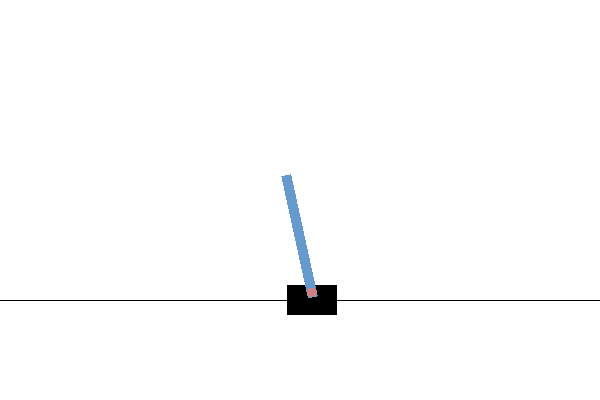

In [ ]:
cv2_imshow(img)

In [ ]:
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_rgb_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)#(240, 160),img_rgb

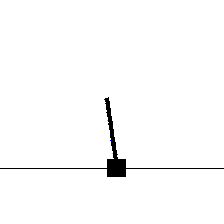

(224, 224, 3)


In [ ]:
img_rgb_resized[img_rgb_resized < 255] = 0
cv2_imshow(img_rgb_resized)
print(img_rgb_resized.shape)

In [8]:
import os
import random
import gym
import pylab
import numpy as np
from collections import deque
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from PER import *
import cv2

import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

#Use seed for reproducibility of results
seedval = 2018
np.random.seed(seedval)
    

class DQNAgent:
    def __init__(self, env_name):
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.env.seed(0)  
        # by default, CartPole-v1 has max episode steps = 500
        # we can use this to experiment beyond 500
        self.env._max_episode_steps = 4000
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.EPISODES = 1000
        
        # Instantiate memory
        memory_size = 10000
        self.MEMORY = Memory(memory_size)
        self.memory = deque(maxlen=2000)

        self.gamma = 0.95    # discount rate
        
        # EXPLORATION HYPERPARAMETERS for epsilon and epsilon greedy strategy
        self.epsilon = 1.0  # exploration probability at start
        self.epsilon_min = 0.01  # minimum exploration probability 
        self.epsilon_decay = 0.0005  # exponential decay rate for exploration prob
        
        self.batch_size = 1024

        # defining model parameters
        self.ddqn = True # use doudle deep q network
        self.Soft_Update = False # use soft parameter update
        self.dueling = True # use dealing netowrk
        self.epsilon_greedy = False # use epsilon greedy strategy
        self.USE_PER = True # use priority experienced replay
        
        self.TAU = 0.1 # target network soft update hyperparameter

        self.Save_Path = 'Models'
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.scores, self.episodes, self.average = [], [], []

        self.Model_name = os.path.join(self.Save_Path, self.env_name+"_PER_D3QN_CNN.h5")

        self.ROWS = 160
        self.COLS = 240
        self.REM_STEP = 4

        self.image_memory = np.zeros((self.REM_STEP, self.ROWS, self.COLS))
        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        
        # create main model and target model
        #self.model = OurModel(input_shape=self.state_size, action_space = self.action_size, dueling = self.dueling)
        #self.target_model = OurModel(input_shape=self.state_size, action_space = self.action_size, dueling = self.dueling)  


    #function to calculate accuracy
    def accuracy_score(self, y, y_pred):
    
      acc = np.mean(y == y_pred)
      return acc


    #function to calculate netsum and prediction for one instance
    def predictOne(self, W, X, thres):
    
      netsum = np.sum(W * X) #net sum
    
      #threshold check
      if netsum >= thres:
        y_hat = 1
      else:
        y_hat = 0
    
      return y_hat


    #function to calculate netsums and predictions for all instances
    def predictAll(self, W, X, thres):
    
      NetSum = np.dot(X, W)
      Idx = np.where(NetSum >= thres)
      y_pred = np.zeros(X.shape[0])
      y_pred[Idx] = 1
    
      return y_pred


    #function to compute and print the classification summary
    def ComputePerf(self, W, X, y, thres, print_flag = False):
    
      y_pred = self.predictAll(W, X, thres) #compute the prediction
      acc = self.accuracy_score(y, y_pred) #compute accuracy

      #print the summary if printflag is True
      if print_flag == True:
        print('Accuracy:',acc)
        #print(confusion_matrix(y, y_pred))
        #print(classification_report(y, y_pred))
    
      return acc


    #function to train Winnow2 using grid-search (optional)
    def TrainWinnow2(self, X_train, y_train, X_val, y_val, params, max_epoch=10, patience=20, verbose=False):
    
      n = X_train.shape[1]
      best_perf = 0. #best val set performance so far
      grid_space = len(params['Alpha'])*len(params['Thres']) #size of grid space
      grid_iter = 0 #grid search iterator
    
      #model dictionary
      model = {'W': [], 
               'alpha': None, 
              'thres': None, 
              'train_perf': 0.,
              'val_perf': 0.}
    
      #grid search and training
      for alpha in params['Alpha']:
        
          for thres in params['Thres']:
            
              grid_iter += 1
        
              print('-----------------------------------------------------------------')
              print('Trying::\t alpha:',alpha,'threshold:',thres,'\t(',grid_iter,'of',grid_space,')')
              print('-----------------------------------------------------------------')
            
              W = np.ones(n) #winnow2 initialisation
              piter = 0 #patience iteration
              modelfound = False #model found flag

              for epoch in range(0,max_epoch):
                
                  #Winnow loop (computation and update) starts
                  for i in range(1, X_train.shape[0]):
                    
                     y_hat = self.predictOne(W, X_train[i,:], thres)

                     #Winnow prediction is a mismatch
                     if y_train[i] != y_hat:

                          #active attribute indices
                          Idx = np.where(X_train[i,:] == 1)

                          if y_hat == 0: 
                              W[Idx] *= alpha #netsum was too small (promotion step)

                          else:
                              W[Idx] /= alpha #netsum was too high (demotion step)

                
                  #compute performance on val set
                  val_perf = self.ComputePerf(W, X_val, y_val, thres)
                
                
                  if verbose == True:
                      train_perf  = self.ComputePerf(W, X_train, y_train, thres)
                      print('[Epoch %d] train_perf: %6.4f \tval_perf: %6.4f'%(epoch, train_perf,val_perf))

                  #is it a better model
                  if val_perf > best_perf:
                      best_perf = val_perf
                      piter = 0 #reset the patience count
                      modelfound = True #model is found
                      train_perf  = self.ComputePerf(W, X_train, y_train, thres)
                    
                      #update the model with new params
                      model['W'] = W.copy() #optima W
                      model['alpha'] = alpha #optimal alpha
                      model['thres'] = thres #optimal threshold
                      model['train_perf'] = train_perf #training performance
                      model['val_perf'] = val_perf #validation performance
                    
                      print('[Selected] at epoch',epoch,
                            '\ttrain_perf: %6.4f \tval_perf: %6.4f'%(train_perf,val_perf))
                    
                  else:
                      piter = piter + 1
                
                  if piter >= patience:
                      print('Stopping early after epoch',(epoch+1))
                      break

              if modelfound == False:
                  print('No better model found.\n')
              else:
                  print('Model found and saved.\n')
    
      return model


    #main function
    def run_winnow2(self, vgg_features, target_action, batch_size):

      #call function to get the splits
      X_train, X_val, y_train, y_val = train_test_split(vgg_features, target_action, test_size=0.30, random_state=42)
      X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.15, random_state=42)
      #X_train, y_train, X_val, y_val, X_test, y_test = load_data(trainfile='train.csv', testfile='test.csv')

      #Winnow2 algorithm hyperparameters (will be decided based on a validation set)
      n = X_train.shape[1] #number of features
      Thres = [n, n//2] #decision threshold
      Alpha = [2, 3, 4] #multiplicative factor for weight (promotion or demotion)

      #algorithm param dict
      params = {'Thres': Thres, 'Alpha': Alpha}

      #trainign hyperparameters
      patience = 20 #patience period for early-stopping
      max_epoch = 200 #maximum Winnow epochs

      #call for training and model selection
      model = self.TrainWinnow2(X_train, y_train, 
                           X_val, y_val, 
                           params=params, 
                           max_epoch=max_epoch, 
                           patience=20, 
                           verbose=False)


      #Optimal hyperparameters for Winnow2 using validation set
      print('Best model:', model)

      #test the performance of model on test set
      acc = self.ComputePerf(model['W'], X_test, y_test, model['thres'])
      print('Independent test accuracy:',acc)

      #store the results
      with open('score.txt','w') as fp:
          fp.write(str(acc)+'\n')
      fp.close()

      #save the trained model (dict)
      with open('model.pkl', 'wb') as fp:
          pickle.dump(model, fp, pickle.HIGHEST_PROTOCOL)
      fp.close()


      #load and test the saved model
      #with open('model.pkl', 'rb') as fp:
      #    savedmodel = pickle.load(fp)
      #acc = ComputePerf(model['W'], X_test, y_test, model['thres'])
      #print(acc)
      #print(classification_report(y_test, predictAll(W, X_test, thres)))
      #fp.close()
      return


    # after some time interval update the target model to be same with model
    def update_target_model(self):
        if not self.Soft_Update and self.ddqn:
            self.target_model.set_weights(self.model.get_weights())
            return
        if self.Soft_Update and self.ddqn:
            q_model_theta = self.model.get_weights()
            target_model_theta = self.target_model.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_model.set_weights(target_model_theta)

    def remember(self, state, action, reward, next_state, done):
        experience = state, action, reward, next_state, done
        if self.USE_PER:
            self.MEMORY.store(experience)
        else:
            self.memory.append((experience))

    def act(self, state, decay_step):
        # EPSILON GREEDY STRATEGY
        if self.epsilon_greedy:
        # Here we'll use an improved version of our epsilon greedy strategy for Q-learning
            explore_probability = self.epsilon_min + (self.epsilon - self.epsilon_min) * np.exp(-self.epsilon_decay * decay_step)
        # OLD EPSILON STRATEGY
        else:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= (1-self.epsilon_decay)
            explore_probability = self.epsilon
    
        if explore_probability > np.random.rand():
            # Make a random action (exploration)
            return random.randrange(self.action_size), explore_probability
        else:
            # Get action from Q-network (exploitation)
            # Estimate the Qs values state
            # Take the biggest Q value (= the best action)
            return np.argmax(self.model.predict(state)), explore_probability
                
    def replay(self):
        if self.USE_PER:
            # Sample minibatch from the PER memory
            tree_idx, minibatch  = self.MEMORY.sample(self.batch_size)
        else:
            # Randomly sample minibatch from the deque memory
            minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        state = np.zeros((self.batch_size,) + self.state_size)
        next_state = np.zeros((self.batch_size,) + self.state_size)
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop       
        for i in range(len(minibatch)):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        # predict Q-values for starting state using the main network
        #target = self.model.predict(state)
        #target_old = np.array(target)
        # predict best action in ending state using the main network
        #target_next = self.model.predict(next_state)
        # predict Q-values for ending state using the target network
        #target_val = self.target_model.predict(next_state)

        #for i in range(len(minibatch)):
            # correction on the Q value for the action used
        #    if done[i]:
                #target[i][action[i]] = reward[i]
                #action[i] = reward[i]
        #    else:
                # the key point of Double DQN
                # selection of action is from model
                # update is from target model
        #        if self.ddqn: # Double - DQN
                    # current Q Network selects the action
                    # a'_max = argmax_a' Q(s', a')
        #            a = np.argmax(target_next[i])
                    # target Q Network evaluates the action
                    # Q_max = Q_target(s', a'_max)
        #            target[i][action[i]] = reward[i] + self.gamma * (target_val[i][a])
        #        else: # Standard - DQN
                    # DQN chooses the max Q value among next actions
                    # selection and evaluation of action is on the target Q Network
                    # Q_max = max_a' Q_target(s', a')
        #           target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        #    if self.USE_PER:
        #        absolute_errors = np.abs(target_old[i]-target[i])
                # Update priority
        #        self.MEMORY.batch_update(tree_idx, absolute_errors)
                
        # Train the Neural Network with batches
        #print(state.shape,target.shape)
        

        model = VGG16(weights='imagenet', include_top=False)
        #model.summary()
        state = state.reshape(state.shape[0], state.shape[2], state.shape[3], state.shape[1])
        resized_state = np.zeros((state.shape[0],224,224,state.shape[3]))
        for img_no in range(state.shape[0]):
          for frame_no in range(state.shape[3]):
            resized_state[img_no,:,:,frame_no] = cv2.resize(state[img_no,:,:,frame_no], (224, 224), interpolation=cv2.INTER_CUBIC)#(240, 160),img_rgb
            resized_state[img_no,:,:,frame_no] = np.expand_dims(resized_state[img_no,:,:,frame_no], axis=0)
            resized_state[img_no,:,:,frame_no] = preprocess_input(resized_state[img_no,:,:,frame_no])

        vgg16_feature = Flatten()(model.predict(resized_state[:,:,:,1:]))
        print(vgg16_feature.shape)
        print(len(action), action[0])
        mean_arr = np.mean(vgg16_feature,axis=1)
        print(mean_arr.shape)
        binary_features=[]
        for feat_no in range(vgg16_feature.shape[0]):
          temp_feat = vgg16_feature[feat_no]
          temp_feat = np.where(temp_feat<mean_arr[feat_no], 0, 1)
          binary_features.append(temp_feat)
        binary_features = np.array(binary_features)
        print(binary_features.shape, binary_features[binary_features!=0], binary_features[binary_features!=1])
        #self.model.fit(state, target, batch_size=self.batch_size, verbose=0)
        self.run_winnow2(vgg_features=binary_features, target_action=action, batch_size=self.batch_size)

    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        pylab.plot(self.episodes, self.average, 'r')
        pylab.plot(self.episodes, self.scores, 'b')
        pylab.ylabel('Score', fontsize=18)
        pylab.xlabel('Steps', fontsize=18)
        dqn = 'DQN_'
        softupdate = ''
        dueling = ''
        greedy = ''
        PER = ''
        if self.ddqn: dqn = 'DDQN_'
        if self.Soft_Update: softupdate = '_soft'
        if self.dueling: dueling = '_Dueling'
        if self.epsilon_greedy: greedy = '_Greedy'
        if self.USE_PER: PER = '_PER'
        try:
            pylab.savefig(dqn+self.env_name+softupdate+dueling+greedy+PER+"_CNN.png")
        except OSError:
            pass

        return str(self.average[-1])[:5]

    def imshow(self, image, rem_step=0):
        print("cartpole"+str(rem_step))
        cv2_imshow(image[rem_step,...])
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return

    def GetImage(self):
        img = self.env.render(mode='rgb_array')
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_rgb_resized = cv2.resize(img_rgb, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)
        img_rgb_resized[img_rgb_resized < 255] = 0
        img_rgb_resized = img_rgb_resized / 255

        self.image_memory = np.roll(self.image_memory, 1, axis = 0)
        self.image_memory[0,:,:] = img_rgb_resized

        #self.imshow(self.image_memory,0)
        
        return np.expand_dims(self.image_memory, axis=0)

    def reset(self):
        self.env.reset()
        for i in range(self.REM_STEP):
            state = self.GetImage()
        return state

    def step(self,action):
        next_state, reward, done, info = self.env.step(action)
        next_state = self.GetImage()
        return next_state, reward, done, info
    
    def run(self):
        decay_step = 0
        for e in range(self.EPISODES):
            state = self.reset()
            done = False
            i = 0
            while not done:
                decay_step += 1
                action, explore_probability = self.act(state, decay_step)
                next_state, reward, done, _ = self.step(action)
                if not done or i == self.env._max_episode_steps-1:
                    reward = reward
                else:
                    reward = -100
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:
                    # every REM_STEP update target model
                    if e % self.REM_STEP == 0:
                        #self.update_target_model()
                        print()
                    
                    # every episode, plot the result
                    average = self.PlotModel(i, e)
                    
                    print("episode: {}/{}, score: {}, e: {:.2}, average: {}".format(e, self.EPISODES, i, explore_probability, average))
                    if i == self.env._max_episode_steps:
                        print("Saving trained model to", self.Model_name)
                        #self.save(self.Model_name)
                        break
                self.replay()

    def test(self):
        self.load(self.Model_name)
        for e in range(self.EPISODES):
            state = self.reset()
            done = False
            i = 0
            while not done:
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = env.step(action)
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, i))
                    break

if __name__ == "__main__":
    env_name = 'CartPole-v1'
    agent = DQNAgent(env_name)
    agent.run()
    #agent.test()

(1024, 25088)
1024 0
(1024,)
(1024, 25088) [1 1 1 ... 1 1 1] [0 0 0 ... 0 0 0]
-----------------------------------------------------------------
Trying::	 alpha: 2 threshold: 25088 	( 1 of 6 )
-----------------------------------------------------------------
[Selected] at epoch 0 	train_perf: 1.0000 	val_perf: 1.0000
Stopping early after epoch 21
Model found and saved.

-----------------------------------------------------------------
Trying::	 alpha: 2 threshold: 12544 	( 2 of 6 )
-----------------------------------------------------------------
Stopping early after epoch 20
No better model found.

-----------------------------------------------------------------
Trying::	 alpha: 3 threshold: 25088 	( 3 of 6 )
-----------------------------------------------------------------
Stopping early after epoch 20
No better model found.

-----------------------------------------------------------------
Trying::	 alpha: 3 threshold: 12544 	( 4 of 6 )
---------------------------------------------

KeyboardInterrupt: ignored

<Figure size 1296x648 with 0 Axes>

In [ ]:
ls

PER.ipynb  PER.py  Untitled1.ipynb


In [ ]:
# Tutorial by www.pylessons.com
# Tutorial written for - Tensorflow 1.15, Keras 2.2.4

import os
import random
import gym
import pylab
import numpy as np
from collections import deque
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from PER import *
import cv2

def OurModel(input_shape, action_space, dueling):
    X_input = Input(input_shape)
    X = X_input
    
    X = Conv2D(64, 5, strides=(3, 3),padding="valid", input_shape=input_shape, activation="relu", data_format="channels_first")(X)
    X = Conv2D(64, 4, strides=(2, 2),padding="valid", activation="relu", data_format="channels_first")(X)
    X = Conv2D(64, 3, strides=(1, 1),padding="valid", activation="relu", data_format="channels_first")(X)
    X = Flatten()(X)
    # 'Dense' is the basic form of a neural network layer
    # Input Layer of state size(4) and Hidden Layer with 512 nodes
    X = Dense(512, activation="relu", kernel_initializer='he_uniform')(X)

    # Hidden layer with 256 nodes
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)
    
    # Hidden layer with 64 nodes
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)

    if dueling:
        state_value = Dense(1, kernel_initializer='he_uniform')(X)
        state_value = Lambda(lambda s: K.expand_dims(s[:, 0], -1), output_shape=(action_space,))(state_value)

        action_advantage = Dense(action_space, kernel_initializer='he_uniform')(X)
        action_advantage = Lambda(lambda a: a[:, :] - K.mean(a[:, :], keepdims=True), output_shape=(action_space,))(action_advantage)

        X = Add()([state_value, action_advantage])
    else:
        # Output Layer with # of actions: 2 nodes (left, right)
        X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X, name='CartPole_PER_D3QN_CNN_model')
    model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

    model.summary()
    return model

class DQNAgent:
    def __init__(self, env_name):
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.env.seed(0)  
        # by default, CartPole-v1 has max episode steps = 500
        # we can use this to experiment beyond 500
        self.env._max_episode_steps = 4000
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.EPISODES = 1000
        
        # Instantiate memory
        memory_size = 10000
        self.MEMORY = Memory(memory_size)
        self.memory = deque(maxlen=2000)

        self.gamma = 0.95    # discount rate
        
        # EXPLORATION HYPERPARAMETERS for epsilon and epsilon greedy strategy
        self.epsilon = 1.0  # exploration probability at start
        self.epsilon_min = 0.01  # minimum exploration probability 
        self.epsilon_decay = 0.0005  # exponential decay rate for exploration prob
        
        self.batch_size = 32

        # defining model parameters
        self.ddqn = True # use doudle deep q network
        self.Soft_Update = False # use soft parameter update
        self.dueling = True # use dealing netowrk
        self.epsilon_greedy = False # use epsilon greedy strategy
        self.USE_PER = True # use priority experienced replay
        
        self.TAU = 0.1 # target network soft update hyperparameter

        self.Save_Path = 'Models'
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.scores, self.episodes, self.average = [], [], []

        self.Model_name = os.path.join(self.Save_Path, self.env_name+"_PER_D3QN_CNN.h5")

        self.ROWS = 160
        self.COLS = 240
        self.REM_STEP = 4

        self.image_memory = np.zeros((self.REM_STEP, self.ROWS, self.COLS))
        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        
        # create main model and target model
        self.model = OurModel(input_shape=self.state_size, action_space = self.action_size, dueling = self.dueling)
        self.target_model = OurModel(input_shape=self.state_size, action_space = self.action_size, dueling = self.dueling)  

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        if not self.Soft_Update and self.ddqn:
            self.target_model.set_weights(self.model.get_weights())
            return
        if self.Soft_Update and self.ddqn:
            q_model_theta = self.model.get_weights()
            target_model_theta = self.target_model.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_model.set_weights(target_model_theta)

    def remember(self, state, action, reward, next_state, done):
        experience = state, action, reward, next_state, done
        if self.USE_PER:
            self.MEMORY.store(experience)
        else:
            self.memory.append((experience))

    def act(self, state, decay_step):
        # EPSILON GREEDY STRATEGY
        if self.epsilon_greedy:
        # Here we'll use an improved version of our epsilon greedy strategy for Q-learning
            explore_probability = self.epsilon_min + (self.epsilon - self.epsilon_min) * np.exp(-self.epsilon_decay * decay_step)
        # OLD EPSILON STRATEGY
        else:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= (1-self.epsilon_decay)
            explore_probability = self.epsilon
    
        if explore_probability > np.random.rand():
            # Make a random action (exploration)
            return random.randrange(self.action_size), explore_probability
        else:
            # Get action from Q-network (exploitation)
            # Estimate the Qs values state
            # Take the biggest Q value (= the best action)
            return np.argmax(self.model.predict(state)), explore_probability
                
    def replay(self):
        if self.USE_PER:
            # Sample minibatch from the PER memory
            tree_idx, minibatch  = self.MEMORY.sample(self.batch_size)
        else:
            # Randomly sample minibatch from the deque memory
            minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        state = np.zeros((self.batch_size,) + self.state_size)
        next_state = np.zeros((self.batch_size,) + self.state_size)
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop       
        for i in range(len(minibatch)):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        # predict Q-values for starting state using the main network
        target = self.model.predict(state)
        target_old = np.array(target)
        # predict best action in ending state using the main network
        target_next = self.model.predict(next_state)
        # predict Q-values for ending state using the target network
        target_val = self.target_model.predict(next_state)

        for i in range(len(minibatch)):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                # the key point of Double DQN
                # selection of action is from model
                # update is from target model
                if self.ddqn: # Double - DQN
                    # current Q Network selects the action
                    # a'_max = argmax_a' Q(s', a')
                    a = np.argmax(target_next[i])
                    # target Q Network evaluates the action
                    # Q_max = Q_target(s', a'_max)
                    target[i][action[i]] = reward[i] + self.gamma * (target_val[i][a])
                else: # Standard - DQN
                    # DQN chooses the max Q value among next actions
                    # selection and evaluation of action is on the target Q Network
                    # Q_max = max_a' Q_target(s', a')
                    target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

            if self.USE_PER:
                absolute_errors = np.abs(target_old[i]-target[i])
                # Update priority
                self.MEMORY.batch_update(tree_idx, absolute_errors)
                
        # Train the Neural Network with batches
        #print(state.shape,target.shape)
        
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)

    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        pylab.plot(self.episodes, self.average, 'r')
        pylab.plot(self.episodes, self.scores, 'b')
        pylab.ylabel('Score', fontsize=18)
        pylab.xlabel('Steps', fontsize=18)
        dqn = 'DQN_'
        softupdate = ''
        dueling = ''
        greedy = ''
        PER = ''
        if self.ddqn: dqn = 'DDQN_'
        if self.Soft_Update: softupdate = '_soft'
        if self.dueling: dueling = '_Dueling'
        if self.epsilon_greedy: greedy = '_Greedy'
        if self.USE_PER: PER = '_PER'
        try:
            pylab.savefig(dqn+self.env_name+softupdate+dueling+greedy+PER+"_CNN.png")
        except OSError:
            pass

        return str(self.average[-1])[:5]

    def imshow(self, image, rem_step=0):
        print("cartpole"+str(rem_step))
        cv2_imshow(image[rem_step,...])
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return

    def GetImage(self):
        img = self.env.render(mode='rgb_array')
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_rgb_resized = cv2.resize(img_rgb, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)
        img_rgb_resized[img_rgb_resized < 255] = 0
        img_rgb_resized = img_rgb_resized / 255

        self.image_memory = np.roll(self.image_memory, 1, axis = 0)
        self.image_memory[0,:,:] = img_rgb_resized

        #self.imshow(self.image_memory,0)
        
        return np.expand_dims(self.image_memory, axis=0)

    def reset(self):
        self.env.reset()
        for i in range(self.REM_STEP):
            state = self.GetImage()
        return state

    def step(self,action):
        next_state, reward, done, info = self.env.step(action)
        next_state = self.GetImage()
        return next_state, reward, done, info
    
    def run(self):
        decay_step = 0
        for e in range(self.EPISODES):
            state = self.reset()
            done = False
            i = 0
            while not done:
                decay_step += 1
                action, explore_probability = self.act(state, decay_step)
                next_state, reward, done, _ = self.step(action)
                if not done or i == self.env._max_episode_steps-1:
                    reward = reward
                else:
                    reward = -100
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:
                    # every REM_STEP update target model
                    if e % self.REM_STEP == 0:
                        self.update_target_model()
                    
                    # every episode, plot the result
                    average = self.PlotModel(i, e)
                    
                    print("episode: {}/{}, score: {}, e: {:.2}, average: {}".format(e, self.EPISODES, i, explore_probability, average))
                    if i == self.env._max_episode_steps:
                        print("Saving trained model to", self.Model_name)
                        #self.save(self.Model_name)
                        break
                self.replay()

    def test(self):
        self.load(self.Model_name)
        for e in range(self.EPISODES):
            state = self.reset()
            done = False
            i = 0
            while not done:
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = env.step(action)
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, i))
                    break

if __name__ == "__main__":
    env_name = 'CartPole-v1'
    agent = DQNAgent(env_name)
    agent.run()
    #agent.test()

Streaming output truncated to the last 5000 lines.
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
episode: 82/1000, score: 25, e: 0.39, average: 23.9
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 240) (32, 2)
(32, 4, 160, 

In [ ]:
pip show pyglet

Name: pyglet
Version: 1.5.0
Summary: Cross-platform windowing and multimedia library
Home-page: http://pyglet.readthedocs.org/en/latest/
Author: Alex Holkner
Author-email: Alex.Holkner@gmail.com
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: future
Required-by: gym


In [ ]:
pip show gym

Name: gym
Version: 0.17.2
Summary: The OpenAI Gym: A toolkit for developing and comparing your reinforcement learning agents.
Home-page: https://github.com/openai/gym
Author: OpenAI
Author-email: gym@openai.com
License: UNKNOWN
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, scipy, pyglet, cloudpickle
Required-by: dopamine-rl


In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)
model.summary()

img_path = 'train/dogs/1.jpg'
#img = image.load_img(img_path, target_size=(224, 224))
#img_data = image.img_to_array(img)
img_data = img_rgb_resized
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

vgg16_feature = model.predict(img_data)
print(vgg16_feature.shape)
print (vgg16_feature)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
vgg16_feature[vgg16_feature<0]

array([], dtype=float32)

In [ ]:
np.mean(vgg16_feature),np.std(vgg16_feature)

(0.9126757, 6.970484)

In [ ]:
import pandas as pd # Import Pandas library 
import numpy as np # Import Numpy library
 
# File name: winnow2.py
# Author: Addison Sears-Collins
# Date created: 5/31/2019
# Python version: 3.7
# Description: Implementation of the Winnow2 machine learning
# algorithm invented by Nick Littlestone. Used for 2-class classificaiton
# problems (e.g. cancer/no cancer....spam/not spam, etc...)
# Nick Littlestone (1988). "Learning Quickly When Irrelevant Attributes 
# Abound: A New Linear-threshold Algorithm", Machine Learning 285–318(2)
 
# Required Data Set Format:
# Columns (0 through N)
# 0: Instance ID
# 1: Attribute 1 (in binary)
# 2: Attribute 2 (in binary)
# 3: Attribute 3 (in binary)
# ...
# N: Actual Class (in binary)
 
# This program then adds 8 additional columns:
# N + 1: Weighted Sum (of the attributes)
# N + 2: Predicted Class (in binary)...Weighted Sum > 0? (1 if yes; 0 if no)
# N + 3: True Positive (1 if yes; O if no)
# N + 4: False Positive (1 if yes; 0 if no)
# N + 5: False Negative (1 if yes; 0 if no)
# N + 6: True Negative (1 if yes; 0 if no)
# N + 7: Promote (1 if yes; 0 if no) [for training set only]
# N + 8: Demote (1 if yes; 0 if no)  [for training set only]
 
################ INPUT YOUR OWN VALUES IN THIS SECTION ######################
ALGORITHM_NAME = "Winnow2"
THETA = 0.5   # This is the threshold constant for the Winnow2 algorithm
ALPHA = 2.0    # This is the adjustment constant for promotion & demotion
DATA_PATH = "breast_cancer_dataset.txt"  # Directory where data set is located
TRAIN_WEIGHTS_FILE = "breast_cancer_winnow2_train_weights.txt" # Weights of learned model
TRAIN_OUT_FILE = "breast_cancer_winnow2_train_out.txt" # Training phase of the model
TEST_STATS_FILE = "breast_cancer_winnow2_test_stats.txt" # Testing statistics
TEST_OUT_FILE = "breast_cancer_winnow2_test_out.txt" # Testing phase of the model
SEPARATOR = ","  # Separator for the data set (e.g. "\t" for tab data)
CLASS_IF_ONE = "Malignant" # If Class value is 1 (e.g. Malignant, Spam, etc.)
CLASS_IF_ZERO = "Benign"  # If Class value is 0 (e.g. Benign, Not Spam, etc.)
TRAINING_DATA_PRCT = 0.67 # % of data set used for training
testing_data_prct = 1 - TRAINING_DATA_PRCT # % of data set used for testing
SEED = 99  # SEED for the random number generator. Default: 99
#############################################################################
 
# Read a text file and store records in a Pandas dataframe
pd_data = pd.read_csv(DATA_PATH, sep=SEPARATOR)
 
# Create a training dataframe by sampling random instances from original data.
# random_state guarantees that the pseudo-random number generator generates 
# the same sequence of random numbers each time.
pd_training_data = pd_data.sample(frac=TRAINING_DATA_PRCT, random_state=SEED)
 
# Create a testing dataframe. Dropping the training data from the original
# dataframe ensures training and testing dataframes have different instances
pd_testing_data = pd_data.drop(pd_training_data.index)
 
# Convert training dataframes to Numpy arrays
np_training_data = pd_training_data.values
np_testing_data = pd_testing_data.values
 
#np_training_data = pd_data.values # Used for testing only
#np_testing_data = pd_data.values  # Used for testing only
 
################ Begin Training Phase #####################################
 
# Calculate the number of instances, columns, and attributes in the data set
# Assumes 1 column for the instance ID and 1 column for the class
# Record the index of the column that contains the actual class
no_of_instances = np_training_data.shape[0]
no_of_columns = np_training_data.shape[1]
no_of_attributes = no_of_columns - 2
actual_class_column = no_of_columns - 1
 
# Initialize the weight vector. Initialize all weights to 1.
# First column of weight vector is not used (i.e. Instance ID)
weights = np.ones(no_of_attributes + 1)
 
# Create a new array that has 8 columns, initialized to 99 for each value
extra_columns_train = np.full((no_of_instances, 8),99)
 
# Add extra columns to the training data set
np_training_data = np.append(np_training_data, extra_columns_train, axis=1)
 
# Make sure it is an array of floats
np_training_data = np_training_data.astype(float)
 
# Build the learning model one instance at a time
for row in range(0, no_of_instances):
 
    # Set the weighted sum to 0
    weighted_sum = 0
 
    # Calculate the weighted sum of the attributes
    for col in range(1, no_of_attributes + 1):
        weighted_sum += (weights[col] * np_training_data[row,col])
 
    # Record the weighted sum into column N + 1, the column just to the right
    # of the actual class column
    np_training_data[row, actual_class_column + 1] = weighted_sum
 
    # Set the predicted class to 99
    predicted_class = 99
 
    # Learner's prediction: Is the weighted sum > THETA?
    if weighted_sum > THETA:
        predicted_class = 1
    else:
        predicted_class = 0
 
    # Record the predicted class into column N + 2
    np_training_data[row, actual_class_column + 2] = predicted_class
 
    # Record the actual class into a variable
    actual_class = np_training_data[row, actual_class_column]
 
    # Initialize the prediction outcomes
    # These variables are standard inputs into a "Confusion Matrix"
    true_positive = 0   # Predicted class = 1; Actual class = 1 (hit)
    false_positive = 0  # Predicted class = 1; Actual class = 0 (false alarm)
    false_negative = 0  # Predicted class = 0; Actual class = 1 (miss)
    true_negative = 0   # Predicted class = 0; Actual class = 0 
 
    # Determine the outcome of the Learner's prediction
    if predicted_class == 1 and actual_class == 1:
        true_positive = 1
    elif predicted_class == 1 and actual_class == 0:
        false_positive = 1
    elif predicted_class == 0 and actual_class == 1:
        false_negative = 1
    else:
        true_negative = 1
 
    # Record the outcome of the Learner's prediction
    np_training_data[row, actual_class_column + 3] = true_positive
    np_training_data[row, actual_class_column + 4] = false_positive
    np_training_data[row, actual_class_column + 5] = false_negative
    np_training_data[row, actual_class_column + 6] = true_negative
 
    # Set the promote and demote variables to 0
    promote = 0
    demote = 0
 
    # Promote if false negative
    if false_negative == 1:
        promote = 1
    
    # Demote if false positive
    if false_positive == 1:
        demote = 1
 
    # Record if either a promotion or demotion is needed
    np_training_data[row, actual_class_column + 7] = promote
    np_training_data[row, actual_class_column + 8] = demote
 
    # Run through each attribute and see if it is equal to 1
    # If attribute is 1, we need to either demote or promote (adjust the
    # corresponding weight by ALPHA).
    if demote == 1:
        for col in range(1, no_of_attributes + 1):
            if(np_training_data[row,col] == 1):
                weights[col] /= ALPHA
    if promote == 1:
        for col in range(1, no_of_attributes + 1):
            if(np_training_data[row,col] == 1):
                weights[col] *= ALPHA
 
# Open a new file to save the weights
outfile1 = open(TRAIN_WEIGHTS_FILE,"w") 
 
# Write the weights of the Learned model to a file
outfile1.write("----------------------------------------------------------\n")
outfile1.write(" " + ALGORITHM_NAME + " Training Weights\n")
outfile1.write("----------------------------------------------------------\n")
outfile1.write("Data Set : " + DATA_PATH + "\n")
outfile1.write("\n----------------------------\n")
outfile1.write("Weights of the Learned Model\n")
outfile1.write("----------------------------\n")
for col in range(1, no_of_attributes + 1):
    colname = pd_training_data.columns[col]
    s = str(weights[col])
    outfile1.write(colname + " : " + s + "\n")
 
# Write the relevant constants used in the model to a file
outfile1.write("\n")
outfile1.write("\n")
outfile1.write("-----------\n")
outfile1.write("Constants\n")
outfile1.write("-----------\n")
s = str(THETA)
outfile1.write("THETA = " + s + "\n")
s = str(ALPHA)
outfile1.write("ALPHA = " + s + "\n")
 
# Close the weights file
outfile1.close()
 
# Print the weights of the Learned model
print("----------------------------------------------------------")
print(" " + ALGORITHM_NAME + " Results")
print("----------------------------------------------------------")
print("Data Set : " + DATA_PATH)
print()
print()
print("----------------------------")
print("Weights of the Learned Model")
print("----------------------------")
for col in range(1, no_of_attributes + 1):
    colname = pd_training_data.columns[col]
    s = str(weights[col])
    print(colname + " : " + s)
 
# Print the relevant constants used in the model
print()
print()
print("-----------")
print("Constants")
print("-----------")
s = str(THETA)
print("THETA = " + s)
s = str(ALPHA)
print("ALPHA = " + s)
print()
 
# Print the learned model runs in binary form
print("-------------------------------------------------------")
print("Learned Model Runs of the Training Data Set (in binary)")
print("-------------------------------------------------------")
print(np_training_data)
print()
print()
 
# Convert Numpy array to a dataframe
df = pd.DataFrame(data=np_training_data)
 
# Replace 0s and 1s in the attribute columns with False and True
for col in range(1, no_of_attributes + 1):
    df[[col]] = df[[col]].replace([0,1],["False","True"])
 
# Replace values in Actual Class column with more descriptive values
df[[actual_class_column]] = df[[actual_class_column]].replace([0,1],[CLASS_IF_ZERO,CLASS_IF_ONE])
 
# Replace values in Predicted Class column with more descriptive values
df[[actual_class_column + 2]] = df[[actual_class_column + 2]].replace([0,1],[CLASS_IF_ZERO,CLASS_IF_ONE])
 
# Change prediction outcomes to more descriptive values
for col in range(actual_class_column + 3,actual_class_column + 9):
    df[[col]] = df[[col]].replace([0,1],["No","Yes"])
 
# Rename the columns
df.rename(columns={actual_class_column + 1 : "Weighted Sum" }, inplace = True)
df.rename(columns={actual_class_column + 2 : "Predicted Class" }, inplace = True)
df.rename(columns={actual_class_column + 3 : "True Positive" }, inplace = True)
df.rename(columns={actual_class_column + 4 : "False Positive" }, inplace = True)
df.rename(columns={actual_class_column + 5 : "False Negative" }, inplace = True)
df.rename(columns={actual_class_column + 6 : "True Negative" }, inplace = True)
df.rename(columns={actual_class_column + 7 : "Promote" }, inplace = True)
df.rename(columns={actual_class_column + 8 : "Demote" }, inplace = True)
 
# Change remaining columns names from position numbers to descriptive names
for pos in range(0,actual_class_column + 1):
    df.rename(columns={pos : pd_data.columns[pos] }, inplace = True)
 
print("-------------------------------------------------------")
print("Learned Model Runs of the Training Data Set (readable) ")
print("-------------------------------------------------------")
# Print the revamped dataframe
print(df)
 
# Write revamped dataframe to a file
df.to_csv(TRAIN_OUT_FILE, sep=",", header=True)
################ End Training Phase #####################################
 
################ Begin Testing Phase ######################################
 
# Calculate the number of instances, columns, and attributes in the data set
# Assumes 1 column for the instance ID and 1 column for the class
# Record the index of the column that contains the actual class
no_of_instances = np_testing_data.shape[0]
no_of_columns = np_testing_data.shape[1]
no_of_attributes = no_of_columns - 2
actual_class_column = no_of_columns - 1
 
# Create a new array that has 6 columns, initialized to 99 for each value
extra_columns_test = np.full((no_of_instances, 6),99)
 
# Add extra columns to the testing data set
np_testing_data = np.append(np_testing_data, extra_columns_test, axis=1)
 
# Make sure it is an array of floats
np_testing_data = np_testing_data.astype(float)
 
# Test the learning model one instance at a time
for row in range(0, no_of_instances):
 
    # Set the weighted sum to 0
    weighted_sum = 0
 
    # Calculate the weighted sum of the attributes
    for col in range(1, no_of_attributes + 1):
        weighted_sum += (weights[col] * np_testing_data[row,col])
 
    # Record the weighted sum into column N + 1, the column just to the right
    # of the actual class column
    np_testing_data[row, actual_class_column + 1] = weighted_sum
 
    # Set the predicted class to 99
    predicted_class = 99
 
    # Learner's prediction: Is the weighted sum > THETA?
    if weighted_sum > THETA:
        predicted_class = 1
    else:
        predicted_class = 0
 
    # Record the predicted class into column N + 2
    np_testing_data[row, actual_class_column + 2] = predicted_class
 
    # Record the actual class into a variable
    actual_class = np_testing_data[row, actual_class_column]
 
    # Initialize the prediction outcomes
    # These variables are standard inputs into a "Confusion Matrix"
    true_positive = 0   # Predicted class = 1; Actual class = 1 (hit)
    false_positive = 0  # Predicted class = 1; Actual class = 0 (false alarm)
    false_negative = 0  # Predicted class = 0; Actual class = 1 (miss)
    true_negative = 0   # Predicted class = 0; Actual class = 0 
 
    # Determine the outcome of the Learner's prediction
    if predicted_class == 1 and actual_class == 1:
        true_positive = 1
    elif predicted_class == 1 and actual_class == 0:
        false_positive = 1
    elif predicted_class == 0 and actual_class == 1:
        false_negative = 1
    else:
        true_negative = 1
 
    # Record the outcome of the Learner's prediction
    np_testing_data[row, actual_class_column + 3] = true_positive
    np_testing_data[row, actual_class_column + 4] = false_positive
    np_testing_data[row, actual_class_column + 5] = false_negative
    np_testing_data[row, actual_class_column + 6] = true_negative
 
# Convert Numpy array to a dataframe
df = pd.DataFrame(data=np_testing_data)
 
# Replace 0s and 1s in the attribute columns with False and True
for col in range(1, no_of_attributes + 1):
    df[[col]] = df[[col]].replace([0,1],["False","True"])
 
# Replace values in Actual Class column with more descriptive values
df[[actual_class_column]] = df[[actual_class_column]].replace([0,1],[CLASS_IF_ZERO,CLASS_IF_ONE])
 
# Replace values in Predicted Class column with more descriptive values
df[[actual_class_column + 2]] = df[[actual_class_column + 2]].replace([0,1],[CLASS_IF_ZERO,CLASS_IF_ONE])
 
# Change prediction outcomes to more descriptive values
for col in range(actual_class_column + 3,actual_class_column + 7):
    df[[col]] = df[[col]].replace([0,1],["No","Yes"])
 
# Rename the columns
df.rename(columns={actual_class_column + 1 : "Weighted Sum" }, inplace = True)
df.rename(columns={actual_class_column + 2 : "Predicted Class" }, inplace = True)
df.rename(columns={actual_class_column + 3 : "True Positive" }, inplace = True)
df.rename(columns={actual_class_column + 4 : "False Positive" }, inplace = True)
df.rename(columns={actual_class_column + 5 : "False Negative" }, inplace = True)
df.rename(columns={actual_class_column + 6 : "True Negative" }, inplace = True)
 
df_numerical = pd.DataFrame(data=np_testing_data) # Keep the values in this dataframe numerical
df_numerical.rename(columns={actual_class_column + 3 : "True Positive" }, inplace = True)
df_numerical.rename(columns={actual_class_column + 4 : "False Positive" }, inplace = True)
df_numerical.rename(columns={actual_class_column + 5 : "False Negative" }, inplace = True)
df_numerical.rename(columns={actual_class_column + 6 : "True Negative" }, inplace = True)
 
# Change remaining columns names from position numbers to descriptive names
for pos in range(0,actual_class_column + 1):
    df.rename(columns={pos : pd_data.columns[pos] }, inplace = True)
 
print("-------------------------------------------------------")
print("Learned Model Predictions on Testing Data Set")
print("-------------------------------------------------------")
# Print the revamped dataframe
print(df)
 
# Write revamped dataframe to a file
df.to_csv(TEST_OUT_FILE, sep=",", header=True)
 
# Open a new file to save the summary statistics
outfile2 = open(TEST_STATS_FILE,"w") 
 
# Write to a file
outfile2.write("----------------------------------------------------------\n")
outfile2.write(ALGORITHM_NAME + " Summary Statistics (Testing)\n")
outfile2.write("----------------------------------------------------------\n")
outfile2.write("Data Set : " + DATA_PATH + "\n")
 
# Write the relevant stats to a file
outfile2.write("\n")
outfile2.write("Number of Test Instances : " +
    str(np_testing_data.shape[0])+ "\n")
 
tp = df_numerical["True Positive"].sum()
s = str(int(tp))
outfile2.write("True Positives : " + s + "\n")
 
fp = df_numerical["False Positive"].sum()
s = str(int(fp))
outfile2.write("False Positives : " + s + "\n")
 
fn = df_numerical["False Negative"].sum()
s = str(int(fn))
outfile2.write("False Negatives : " + s + "\n")
 
tn = df_numerical["True Negative"].sum()
s = str(int(tn))
outfile2.write("True Negatives : " + s + "\n")
 
accuracy = (tp + tn)/(tp + tn + fp + fn)
accuracy *= 100
s = str(accuracy)
outfile2.write("Accuracy : " + s + "%\n")
 
specificity = (tn)/(tn + fp)
specificity *= 100
s = str(specificity)
outfile2.write("Specificity : " + s + "%\n")
 
precision = (tp)/(tp + fp)
precision *= 100
s = str(precision)
outfile2.write("Precision : " + s + "%\n")
 
recall = (tp)/(tp + fn)
recall *= 100
s = str(recall)
outfile2.write("Recall : " + s + "%\n")
 
neg_pred_value = (tn)/(tn + fn)
neg_pred_value *= 100
s = str(neg_pred_value)
outfile2.write("Negative Predictive Value : " + s + "%\n")
 
miss_rate = (fn)/(fn + tp)
miss_rate *= 100
s = str(miss_rate)
outfile2.write("Miss Rate  : " + s + "%\n")
 
fall_out = (fp)/(fp + tn)
fall_out *= 100
s = str(fall_out)
outfile2.write("Fall-Out : " + s + "%\n")
 
false_discovery_rate = (fp)/(fp + tp)
false_discovery_rate *= 100
s = str(false_discovery_rate)
outfile2.write("False Discovery Rate : " + s + "%\n")
 
false_omission_rate = (fn)/(fn + tn)
false_omission_rate *= 100
s = str(false_omission_rate)
outfile2.write("False Omission Rate  : " + s + "%\n")
 
f1_score = (2 * tp)/((2 * tp) + fp + fn)
s = str(f1_score)
outfile2.write("F1 Score: " + s)
 
# Close the weights file
outfile2.close()
 
# Print statistics to console
print()
print()
print("-------------------------------------------------------")
print(ALGORITHM_NAME + " Summary Statistics (Testing)")
print("-------------------------------------------------------")
print("Data Set : " + DATA_PATH)
 
# Print the relevant stats to the console
print()
print("Number of Test Instances : " +
    str(np_testing_data.shape[0]))
 
s = str(int(tp))
print("True Positives : " + s)
 
s = str(int(fp))
print("False Positives : " + s)
 
s = str(int(fn))
print("False Negatives : " + s)
 
s = str(int(tn))
print("True Negatives : " + s)
 
s = str(accuracy)
print("Accuracy : " + s + "%")
 
s = str(specificity)
print("Specificity : " + s + "%")
 
s = str(precision)
print("Precision : " + s + "%")
 
s = str(recall)
print("Recall : " + s + "%")
 
s = str(neg_pred_value)
print("Negative Predictive Value : " + s + "%")
 
s = str(miss_rate)
print("Miss Rate  : " + s + "%")
 
s = str(fall_out)
print("Fall-Out : " + s + "%")
 
s = str(false_discovery_rate)
print("False Discovery Rate : " + s + "%")
 
s = str(false_omission_rate)
print("False Omission Rate  : " + s + "%")
 
s = str(f1_score)
print("F1 Score: " + s)

 

----------------------------------------------------------
 Winnow2 Results
----------------------------------------------------------
Data Set : breast_cancer_dataset.txt


----------------------------
Weights of the Learned Model
----------------------------
Clump Thickness : 0.25
Uniformity of Cell Size : 0.25
Uniformity of Cell Shape : 0.0625
Marginal Adhesion : 0.5
Single Epithelial Cell Size : 0.25
Bare Nuclei : 0.5
Bland Chromatin : 0.25
Normal Nucleoli : 0.25
Mitoses : 0.5


-----------
Constants
-----------
THETA = 0.5
ALPHA = 2.0

-------------------------------------------------------
Learned Model Runs of the Training Data Set (in binary)
-------------------------------------------------------
[[8.888200e+05 0.000000e+00 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [1.047630e+06 1.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [1.201936e+06 0.000000e+00 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [1.112209e+06 1.00